<a href="https://colab.research.google.com/github/kattens/SASA-Calculation-For-LLMs/blob/main/Base_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Clear the CUDA memory cache
torch.cuda.empty_cache()

# Optionally, collect garbage to free up memory from unused objects
import gc
gc.collect()


1468

In [ ]:
import transformers
import pandas as pd
import csv
import numpy as np
import torch
import torch.nn as nn

# Agenda for the code:
just give the global seq as input and local as label to the model without adding new tokens just do a prediction task simple as this then build up



#outline of the code:
import the dataset

import tokenizer / base model

build dataset class

make the dataloader

split the test and training data

train

test

predict

In [ ]:
pairs_df = pd.read_csv('/home/k_ensafitakaldani001_umb_edu/Project1/merged1.csv')

dataset:
first -> make 1 input from seq A and B
sencond -> make masked seq A and B as their labels

goal: make a model that can predict the local sequences of A and B based on global sequences A and B.


Example:

inputs:
[Entity 1] abweregfvkk [Entity 2] qwmfdefjlxcvg

predictions: predictions should be something like:
[Entity 1] ab---egf--- [Entity 2] ---fde---xcvg

In [ ]:
df = pairs_df
filtered_df = df[(df['Sequence_A'].str.len() >= 50) & (df['Sequence_A'].str.len() < 200)]
print(len(filtered_df))
pairs_df = filtered_df


59960


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertModel, BertConfig, AutoTokenizer

# Initialize the ProtBERT tokenizer and model -> mainly use these for pretraining

# used for a variety of downstream tasks (e.g., classification, tagging). Unlike AutoModelForMaskedLM, it is not specifically tied to masked language modeling
tokenizer = AutoTokenizer.from_pretrained('Rostlab/prot_bert_bfd')
model = BertModel.from_pretrained('Rostlab/prot_bert_bfd')

# Define special tokens for entities
special_tokens = ['[ENTITY1]', '[ENTITY2]', '-', 'BR', 'PE', 'EX']

# Add special tokens to the tokenizer
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})

# Check if the special tokens were added successfully
print(f"Token '[ENTITY1]' has ID: {tokenizer.convert_tokens_to_ids('[ENTITY1]')}")
print(f"Token '[ENTITY2]' has ID: {tokenizer.convert_tokens_to_ids('[ENTITY2]')}")
print(f"Token '-' has ID: {tokenizer.convert_tokens_to_ids('-')}")
print(f"Token 'BR' has ID: {tokenizer.convert_tokens_to_ids('BR')}")
print(f"Token 'PE' has ID: {tokenizer.convert_tokens_to_ids('PE')}")
print(f"Token 'EX' has ID: {tokenizer.convert_tokens_to_ids('EX')}")

# Resize the model's embedding size to accommodate the new tokens
model.resize_token_embeddings(len(tokenizer))
print('Token embeddings resized to accommodate new tokens.')

# Helper function to convert numerical token IDs back to their textual representation
def ids_to_text(ids):
    return ' '.join(tokenizer.convert_ids_to_tokens(ids))

# Check the updated size of the tokenizer's vocabulary
print(f"Updated vocabulary size: {len(tokenizer)}")

# Check if the new tokens are in the tokenizer's vocabulary
if all(token in tokenizer.get_vocab() for token in special_tokens):
    print("All special tokens are in the tokenizer's vocabulary.")
else:
    print("Some special tokens are NOT in the tokenizer's vocabulary.")


Token '[ENTITY1]' has ID: 30
Token '[ENTITY2]' has ID: 31
Token '-' has ID: 32
Token 'BR' has ID: 33
Token 'PE' has ID: 34
Token 'EX' has ID: 35
Token embeddings resized to accommodate new tokens.
Updated vocabulary size: 36
All special tokens are in the tokenizer's vocabulary.


In [ ]:
vocab= tokenizer.get_vocab()

In [ ]:
len(vocab)

36

In [ ]:
# Get the number of amino acids (adjust based on whether you are using a classification task)
num_amino_acids = len(tokenizer.get_vocab())  # Adjust this if your task isn't directly classification
print(num_amino_acids)

36


In [ ]:
#This is a vertsion which we dont need now
import torch
from torch.utils.data import Dataset
class SampleDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def get_SASA_sequence(self, row):
        SASA_A = row['SASA_Category_A']
        SASA_B = row['SASA_Category_B']

        try:
            if isinstance(SASA_A, str):
                SASA_A = SASA_A.split(", ")
            elif not isinstance(SASA_A, list):
                SASA_A = [str(SASA_A)]

            if isinstance(SASA_B, str):
                SASA_B = SASA_B.split(", ")
            elif not isinstance(SASA_B, list):
                SASA_B = [str(SASA_B)]
        except Exception as e:
            print(f"Error processing SASA sequences: {e}")
            print(f"SASA_A: {SASA_A}, SASA_B: {SASA_B}")

        SASA_sequence = f"[ENTITY1] {' '.join(SASA_A)} [SEP] [ENTITY2] {' '.join(SASA_B)}"
        return SASA_sequence

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        Global_Sequence_A = row['Sequence_A']
        Global_Sequence_B = row['Sequence_B']
        Local_Sequence_A = row['masked_sequence_A']
        Local_Sequence_B = row['masked_sequence_B']

        # Enhanced sequences with new tokens
        Global_sequence = f"[ENTITY1] {Global_Sequence_A} [SEP] [ENTITY2] {Global_Sequence_B}"
        Local_sequence = f"[ENTITY1] {Local_Sequence_A} [SEP] [ENTITY2] {Local_Sequence_B}"
        SASA_sequence = self.get_SASA_sequence(row)

        # Tokenize input, label, and SASA sequences
        global_inputs = self.tokenizer(Global_sequence, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_len)
        labels = self.tokenizer(Local_sequence, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_len)
        SASA_inputs = self.tokenizer(SASA_sequence, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_len)

        # Ensure all outputs are properly returned
        return {
            'global_input_ids': global_inputs['input_ids'].squeeze(0),
            'global_attention_mask': global_inputs['attention_mask'].squeeze(0),
            'SASA_input_ids': SASA_inputs['input_ids'].squeeze(0),  # SASA tokenized and part of input
            'SASA_attention_mask': SASA_inputs['attention_mask'].squeeze(0),  # Attention mask for SASA inputs
            'labels': labels['input_ids'].squeeze(0)  # Local sequences as labels
        }

def collate_fn(batch):
    inputs = {k: torch.stack([d[k] for d in batch]) for k in batch[0]}
    return inputs


In [ ]:
'''
#BASE CODE
import torch
import torch.nn as nn

class ProtBertSeq2Seq(nn.Module):
    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):
        super(ProtBertSeq2Seq, self).__init__()
        self.model = model  # The underlying ProtBERT model
        self.seq_len = seq_len  # Sequence length
        self.num_amino_acids = num_amino_acids  # Total number of possible amino acids
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer to prevent overfitting
        # Separate classifiers for each input might be considered depending on the model design
        self.classifier = nn.Linear(model.config.hidden_size * 2, num_amino_acids)  # Classifier to predict amino acids based on concatenated outputs

    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):
        # Process global sequence inputs
        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).last_hidden_state
        global_outputs = self.dropout(global_outputs)

        # Process SASA sequence inputs
        SASA_outputs = self.model(input_ids=SASA_input_ids, attention_mask=SASA_attention_mask).last_hidden_state
        SASA_outputs = self.dropout(SASA_outputs)

        # Combine the outputs from the two channels
        # This simple concatenation can be replaced with more sophisticated methods (e.g., addition, averaging)
        combined_outputs = torch.cat((global_outputs, SASA_outputs), dim=-1)

        # Pass through the classifier to get predictions
        logits = self.classifier(combined_outputs)
        return logits
'''

'\n#BASE CODE\nimport torch\nimport torch.nn as nn\n\nclass ProtBertSeq2Seq(nn.Module):\n    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):\n        super(ProtBertSeq2Seq, self).__init__()\n        self.model = model  # The underlying ProtBERT model\n        self.seq_len = seq_len  # Sequence length\n        self.num_amino_acids = num_amino_acids  # Total number of possible amino acids\n        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer to prevent overfitting\n        # Separate classifiers for each input might be considered depending on the model design\n        self.classifier = nn.Linear(model.config.hidden_size * 2, num_amino_acids)  # Classifier to predict amino acids based on concatenated outputs\n\n    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):\n        # Process global sequence inputs\n        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).l

In [ ]:
'''
#Option 1: Element-wise Multiplication (Hadamard Product)
class ProtBertSeq2Seq(nn.Module):
    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):
        super(ProtBertSeq2Seq, self).__init__()
        self.model = model
        self.seq_len = seq_len
        self.num_amino_acids = num_amino_acids
        self.dropout = nn.Dropout(dropout_rate)

        # Classifier for prediction
        self.classifier = nn.Linear(model.config.hidden_size, num_amino_acids)

    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):
        # Process global sequence inputs
        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).last_hidden_state
        global_outputs = self.dropout(global_outputs)

        # Process SASA sequence inputs
        SASA_outputs = self.model(input_ids=SASA_input_ids, attention_mask=SASA_attention_mask).last_hidden_state
        SASA_outputs = self.dropout(SASA_outputs)

        # Apply element-wise multiplication (Hadamard product)
        combined_outputs = global_outputs * SASA_outputs

        # Pass through classifier
        logits = self.classifier(combined_outputs)
        return logits
'''

'\n#Option 1: Element-wise Multiplication (Hadamard Product)\nclass ProtBertSeq2Seq(nn.Module):\n    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):\n        super(ProtBertSeq2Seq, self).__init__()\n        self.model = model\n        self.seq_len = seq_len\n        self.num_amino_acids = num_amino_acids\n        self.dropout = nn.Dropout(dropout_rate)\n\n        # Classifier for prediction\n        self.classifier = nn.Linear(model.config.hidden_size, num_amino_acids)\n\n    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):\n        # Process global sequence inputs\n        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).last_hidden_state\n        global_outputs = self.dropout(global_outputs)\n\n        # Process SASA sequence inputs\n        SASA_outputs = self.model(input_ids=SASA_input_ids, attention_mask=SASA_attention_mask).last_hidden_state\n        SASA_outputs = 

In [ ]:
'''
#Gated Mechanism
class ProtBertSeq2Seq(nn.Module):
    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):
        super(ProtBertSeq2Seq, self).__init__()
        self.model = model
        self.seq_len = seq_len
        self.num_amino_acids = num_amino_acids
        self.dropout = nn.Dropout(dropout_rate)

        # Gating mechanism to learn weights between global and SASA outputs
        self.gate = nn.Linear(model.config.hidden_size * 2, model.config.hidden_size)

        # Classifier for prediction
        self.classifier = nn.Linear(model.config.hidden_size, num_amino_acids)

    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):
        # Process global sequence inputs
        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).last_hidden_state
        global_outputs = self.dropout(global_outputs)

        # Process SASA sequence inputs
        SASA_outputs = self.model(input_ids=SASA_input_ids, attention_mask=SASA_attention_mask).last_hidden_state
        SASA_outputs = self.dropout(SASA_outputs)

        # Concatenate and apply a gating mechanism to mix the two inputs element-wise
        combined_inputs = torch.cat((global_outputs, SASA_outputs), dim=-1)
        mixed_outputs = torch.sigmoid(self.gate(combined_inputs)) * global_outputs + (1 - torch.sigmoid(self.gate(combined_inputs))) * SASA_outputs

        # Pass through classifier
        logits = self.classifier(mixed_outputs)
        return logits
'''

'\n#Gated Mechanism\nclass ProtBertSeq2Seq(nn.Module):\n    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):\n        super(ProtBertSeq2Seq, self).__init__()\n        self.model = model\n        self.seq_len = seq_len\n        self.num_amino_acids = num_amino_acids\n        self.dropout = nn.Dropout(dropout_rate)\n\n        # Gating mechanism to learn weights between global and SASA outputs\n        self.gate = nn.Linear(model.config.hidden_size * 2, model.config.hidden_size)\n\n        # Classifier for prediction\n        self.classifier = nn.Linear(model.config.hidden_size, num_amino_acids)\n\n    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):\n        # Process global sequence inputs\n        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).last_hidden_state\n        global_outputs = self.dropout(global_outputs)\n\n        # Process SASA sequence inputs\n        SASA_

In [ ]:

#Transformer Encoder Layer
class ProtBertSeq2Seq(nn.Module):
    def __init__(self, model, num_amino_acids, seq_len, dropout_rate=0.1):
        super(ProtBertSeq2Seq, self).__init__()
        self.model = model
        self.seq_len = seq_len
        self.num_amino_acids = num_amino_acids
        self.dropout = nn.Dropout(dropout_rate)

        # Attention layer to mix global and SASA features
        self.attention = nn.MultiheadAttention(embed_dim=model.config.hidden_size, num_heads=8)

        # Classifier for prediction
        self.classifier = nn.Linear(model.config.hidden_size, num_amino_acids)

    def forward(self, global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask):
        # Process global sequence inputs
        global_outputs = self.model(input_ids=global_input_ids, attention_mask=global_attention_mask).last_hidden_state
        global_outputs = self.dropout(global_outputs)

        # Process SASA sequence inputs
        SASA_outputs = self.model(input_ids=SASA_input_ids, attention_mask=SASA_attention_mask).last_hidden_state
        SASA_outputs = self.dropout(SASA_outputs)

        # Apply cross-attention where global attends to SASA
        attn_output, _ = self.attention(global_outputs, SASA_outputs, SASA_outputs)

        # Pass through classifier
        logits = self.classifier(attn_output)
        return logits


In [ ]:
import os
import torch
from torch.cuda.amp import GradScaler, autocast

def save_checkpoint(state, filename="/home/k_ensafitakaldani001_umb_edu/Project1/checkpoint240.pth.tar"):
    torch.save(state, filename)

def train_model(model, dataloader, optimizer, criterion, device, epochs, accumulation_steps=2, checkpoint_path="checkpoint240.pth.tar"):
    model.train()  # Set the model to training mode

    start_epoch = 0
    loss_history = []
    scaler = GradScaler()  # Mixed precision scaler

    # Load checkpoint if it exists
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss_history = checkpoint['loss_history']
        print(f"Loaded checkpoint '{checkpoint_path}' (epoch {checkpoint['epoch']})")

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        for i, batch in enumerate(dataloader):
            global_input_ids = batch['global_input_ids'].to(device)
            global_attention_mask = batch['global_attention_mask'].to(device)
            SASA_input_ids = batch['SASA_input_ids'].to(device)
            SASA_attention_mask = batch['SASA_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            with autocast():  # Mixed precision forward pass
                outputs = model(global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask)
                loss = criterion(outputs.view(-1, model.num_amino_acids), labels.view(-1)) / accumulation_steps

            scaler.scale(loss).backward()  # Scaled backward pass

            if (i + 1) % accumulation_steps == 0:  # Perform optimizer step every few batches
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item() * accumulation_steps  # Accumulate the loss

            if i % 10 == 0:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}')

            # Freeing memory after each batch
            del global_input_ids, global_attention_mask, SASA_input_ids, SASA_attention_mask, labels, loss
            torch.cuda.empty_cache()

        average_loss = total_loss / len(dataloader)
        loss_history.append(average_loss)
        print(f'End of Epoch {epoch + 1}, Average Loss: {average_loss}')

        # Save checkpoint
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss_history': loss_history
        }, filename=checkpoint_path)

    return loss_history


In [ ]:
from torch.utils.data import DataLoader
#split the train and test here
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and validation
train_df, val_df = train_test_split(pairs_df, test_size=0.2, random_state=42)

print(f"Total dataset size: {len(pairs_df)}")
print(f"Training data size: {len(train_df)}")

# Setup DataLoaders for training and validation
train_dataset = SampleDataset(train_df, tokenizer,450)
val_dataset = SampleDataset(val_df, tokenizer, 450)


# Using pin_memory for faster host to device transfer
# Increasing num_workers to use multiple CPU cores for data loading
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn,  num_workers=2, pin_memory=True)

# Log the setup
print(f"Number of batches in train_loader: {len(train_loader)}, Each batch has {train_loader.batch_size} samples.")
print(f"Number of batches in val_loader: {len(val_loader)}, Each batch has {val_loader.batch_size} samples.")


Total dataset size: 59960
Training data size: 47968
Number of batches in train_loader: 11992, Each batch has 4 samples.
Number of batches in val_loader: 2998, Each batch has 4 samples.


In [ ]:
#!pip install peft

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler
from transformers import AutoTokenizer, BertModel  # Ensure you are using BertModel
from peft import LoraModel, LoraConfig

# Load the tokenizer
tokenizer = tokenizer

# Load the base BertModel or similar from transformers suited for your needs
base_model = model  # Replace with your base model

# Get the number of amino acids (adjust based on whether you are using a classification task)
num_amino_acids = len(vocab)  # Adjust this if your task isn't directly classification

# Initialize your custom model with the base model
my_model = ProtBertSeq2Seq(model=base_model, num_amino_acids=num_amino_acids, seq_len=500)

# LoRA configuration
config = LoraConfig(
    task_type="SEQ_2_SEQ_LM",  # Confirm this is your intended task
    r=8,
    lora_alpha=32,
    target_modules=["value", "key"],  # Make sure these modules exist in your base model
    lora_dropout=0.01
)

# Initialize LoRA model with the custom model and specify the adapter name if necessary
lora_model = LoraModel(my_model, config, adapter_name="default")

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lora_model.to(device)

# Optimizer and scheduler setup
optimizer = Adam(lora_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Check parameters and setup
print(f"Total parameters: {sum(p.numel() for p in lora_model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in lora_model.parameters() if p.requires_grad)}")


Total parameters: 425155620
Trainable parameters: 983040


In [ ]:
num_epochs = 10
train_model(lora_model, train_loader, optimizer, criterion, device, num_epochs)

/tmp/ipykernel_1157671/1435818670.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision scaler
/tmp/ipykernel_1157671/1435818670.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision forward pass


Epoch 1, Batch 1, Loss: 1.7951685190200806
Epoch 1, Batch 11, Loss: 1.6856964826583862
Epoch 1, Batch 21, Loss: 1.5770866870880127
Epoch 1, Batch 31, Loss: 1.5171517133712769
Epoch 1, Batch 41, Loss: 1.4789113998413086
Epoch 1, Batch 51, Loss: 1.4645969867706299
Epoch 1, Batch 61, Loss: 1.4494715929031372
Epoch 1, Batch 71, Loss: 1.427311897277832
Epoch 1, Batch 81, Loss: 1.4206254482269287
Epoch 1, Batch 91, Loss: 1.4181959629058838
Epoch 1, Batch 101, Loss: 1.4227018356323242
Epoch 1, Batch 111, Loss: 1.4049453735351562
Epoch 1, Batch 121, Loss: 1.3932123184204102
Epoch 1, Batch 131, Loss: 1.3847213983535767
Epoch 1, Batch 141, Loss: 1.382173776626587
Epoch 1, Batch 151, Loss: 1.378298044204712
Epoch 1, Batch 161, Loss: 1.3815128803253174
Epoch 1, Batch 171, Loss: 1.3645168542861938
Epoch 1, Batch 181, Loss: 1.3843140602111816
Epoch 1, Batch 191, Loss: 1.3688852787017822
Epoch 1, Batch 201, Loss: 1.3743925094604492
Epoch 1, Batch 211, Loss: 1.3661781549453735
Epoch 1, Batch 221, Loss

In [ ]:
#Already saved loss for the training. the checkpoints are also saved

#loss history for under 240
loss_history =[1.2644726806950528,
 1.242887128370729,
 1.2066624065750828,
 1.2070949814920082,
 1.206244443510456,
 1.2060478101701662,
 1.205697778779031,
 1.2053182708883476,
 1.2058163822979422,
 1.2062993284159562]



'''
average loss for multipication approach:
 2, Batch 11801, Loss: 1.0300836563110352
Epoch 2, Batch 11811, Loss: 1.082323431968689
Epoch 2, Batch 11821, Loss: 1.0216240882873535
Epoch 2, Batch 11831, Loss: 1.0629262924194336
Epoch 2, Batch 11841, Loss: 1.0521647930145264
Epoch 2, Batch 11851, Loss: 1.0114256143569946
Epoch 2, Batch 11861, Loss: 1.0096522569656372
Epoch 2, Batch 11871, Loss: 1.0902949571609497
Epoch 2, Batch 11881, Loss: 1.03969144821167
Epoch 2, Batch 11891, Loss: 1.0338724851608276
Epoch 2, Batch 11901, Loss: 1.0221905708312988
Epoch 2, Batch 11911, Loss: 1.021114468574524
Epoch 2, Batch 11921, Loss: 1.0229949951171875
Epoch 2, Batch 11931, Loss: 1.037742018699646
Epoch 2, Batch 11941, Loss: 1.0248881578445435
Epoch 2, Batch 11951, Loss: 1.0436757802963257
Epoch 2, Batch 11961, Loss: 1.025509238243103
Epoch 2, Batch 11971, Loss: 1.0162767171859741
Epoch 2, Batch 11981, Loss: 1.027431607246399
Epoch 2, Batch 11991, Loss: 1.017958641052246
End of Epoch 2, Average Loss: 2.0710250906064718

'''


'''
Epoch 2, Batch 11921, Loss: 0.6252635717391968
Epoch 2, Batch 11931, Loss: 0.6343806982040405
Epoch 2, Batch 11941, Loss: 0.6306359171867371
Epoch 2, Batch 11951, Loss: 0.6510419845581055
Epoch 2, Batch 11961, Loss: 0.665947437286377
Epoch 2, Batch 11971, Loss: 0.6621376276016235
Epoch 2, Batch 11981, Loss: 0.6571395397186279
Epoch 2, Batch 11991, Loss: 0.6304044723510742
End of Epoch 2, Average Loss: 1.3146582167791954
'''

'\naverage loss:\n\n'

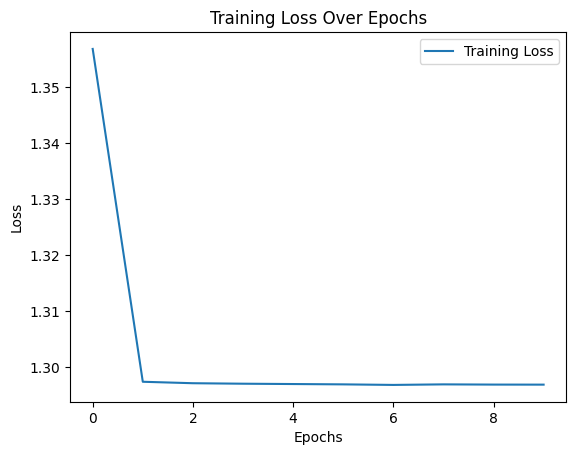

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_history):
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage:
# Assuming 'loss_history' is obtained from 'train_model' function after the model training is complete.
plot_loss(loss_history)


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the performance of a model on a given dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (DataLoader): The DataLoader for the dataset to evaluate.
        criterion (torch.nn.Module): The loss function used for evaluation.
        device (torch.device): The device tensors are sent to (GPU or CPU).

    Returns:
        list, float, float: The loss history for each batch, and the average loss and accuracy over the evaluation dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_examples = 0
    loss_history_val = []  # List to store loss of each batch

    print("Starting evaluation...")
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.view(-1, model.num_amino_acids), labels.view(-1))
            loss_history_val.append(loss.item())  # Append the current loss

            total_loss += loss.item()

            # Convert outputs to probabilities and then to predicted labels
            probs = torch.softmax(outputs, dim=-1)
            predictions = torch.argmax(probs, dim=-1)
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_examples += labels.nelement()

            if i % 10 == 0:  # Print every 10 batches
                print(f'Batch {i+1}: Loss: {loss.item():.4f}, Accuracy: {correct/labels.nelement():.4f}')

    average_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_examples
    print(f'Finished evaluation - Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')
    return loss_history_val, average_loss, accuracy


In [ ]:
# Assume model, validation_dataloader, criterion, and device are already defined
average_loss_val, accuracy = evaluate_model(model, val_loader, criterion, device)
print(f"Validation results - Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


Starting evaluation...
Batch 1: Loss: 1.2339, Accuracy: 0.6535
Batch 11: Loss: 1.1810, Accuracy: 0.8758
Batch 21: Loss: 1.1764, Accuracy: 0.7380
Batch 31: Loss: 1.2086, Accuracy: 0.8458
Batch 41: Loss: 1.1979, Accuracy: 0.6595
Batch 51: Loss: 1.1945, Accuracy: 0.7558
Batch 61: Loss: 1.1849, Accuracy: 0.8505
Batch 71: Loss: 1.1878, Accuracy: 0.7315
Batch 81: Loss: 1.2126, Accuracy: 0.6653
Batch 91: Loss: 1.1950, Accuracy: 0.6388
Batch 101: Loss: 1.2002, Accuracy: 0.7007
Batch 111: Loss: 1.2012, Accuracy: 0.7508
Batch 121: Loss: 1.1775, Accuracy: 0.6577
Batch 131: Loss: 1.1992, Accuracy: 0.5290
Batch 141: Loss: 1.1845, Accuracy: 0.7705
Batch 151: Loss: 1.1726, Accuracy: 0.7192
Batch 161: Loss: 1.2319, Accuracy: 0.6420
Batch 171: Loss: 1.2267, Accuracy: 0.7232
Batch 181: Loss: 1.1901, Accuracy: 0.7907
Batch 191: Loss: 1.2086, Accuracy: 0.7238
Batch 201: Loss: 1.2378, Accuracy: 0.6957
Batch 211: Loss: 1.1899, Accuracy: 0.7308
Batch 221: Loss: 1.2028, Accuracy: 0.6530
Batch 231: Loss: 1.225

ValueError: too many values to unpack (expected 2)

In [ ]:
import matplotlib.pyplot as plt


# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history_val, label='Loss per Batch')
plt.title('Evaluation Loss History')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
